# Signal processing

## Objectives

- Perform digital signal processing on raw strain data from LIGO detectors (Hanford and Livingston).
- Extract weak astrophysical signals (like the GW170817 merger) from high-noise environments using whitening and bandpass filters.
- Visualize time-frequency "chirps" using Spectrograms and Q-transforms to confirm the detection of gravitational waves.

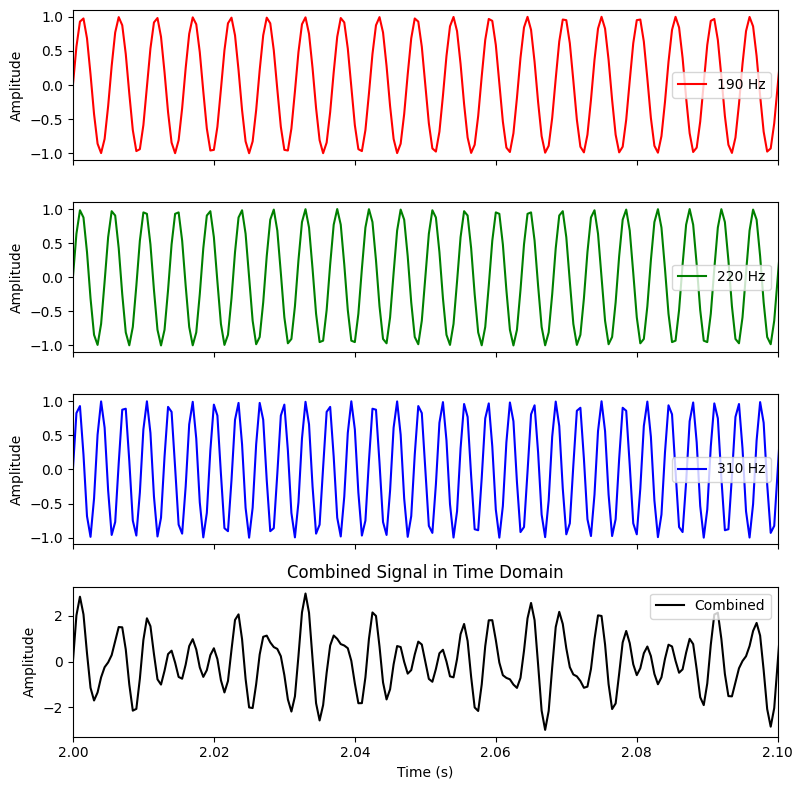

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sample rate and time array
fs = 2000  # Hz
time = np.arange(0, 5, 1/fs)

# Define three sine waves
sine1 = np.sin(2 * np.pi * 190 * time)
sine2 = np.sin(2 * np.pi * 220 * time)
sine3 = np.sin(2 * np.pi * 310 * time)

# Add the components together
data = sine1 + sine2 + sine3

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot individual sine waves
axes[0].plot(time, sine1, label='190 Hz', color='r')
axes[1].plot(time, sine2, label='220 Hz', color='g')
axes[2].plot(time, sine3, label='310 Hz', color='b')

# Plot the combined signal
axes[3].plot(time, data, label='Combined', color='k')

# Formatting
for ax in axes:
    ax.set_xlim(2, 2.1)  # Zoom in on the time range
    ax.legend()
    ax.set_ylabel('Amplitude')

axes[3].set_xlabel('Time (s)')
axes[3].set_title('Combined Signal in Time Domain')

plt.tight_layout()
plt.show()


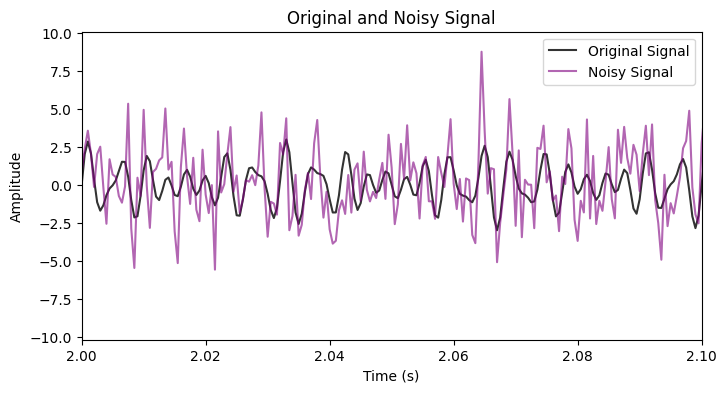

In [2]:
# Generate random noise
noise = np.random.normal(0, 2, len(time))  # Mean 0, standard deviation 0.5

# Add noise to the combined signal
noisy_data = data + noise

# Plot both signals in the same figure
plt.figure(figsize=(8, 4))
plt.plot(time, data, label='Original Signal', color='k', alpha=0.8)
plt.plot(time, noisy_data, label='Noisy Signal', color='purple', alpha=0.6)

# Formatting
plt.xlim(2, 2.1)  # Zoom in on the time range
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original and Noisy Signal')
plt.legend()

plt.show()


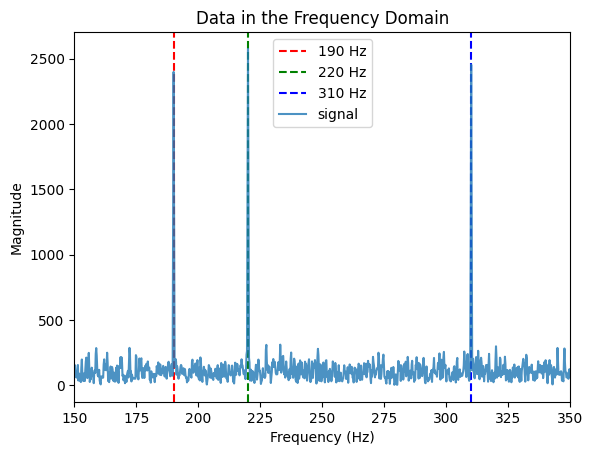

In [3]:
# -- Fast Fourier Transform the signal into the frequency domain

# -- Apply a window
from scipy import signal

# -- The window forces the signal to zeros at the beginning and end.
# -- This must be done before applying a Fourier Transform
window = np.hanning(len(noisy_data))

# -- Apply the real Fast Fourier Transform (rfft)
data_freq = np.fft.rfft((window*noisy_data))
frequencies = np.fft.rfftfreq(len(noisy_data))*fs

plt.axvline(x=190, color='r', linestyle='--', label="190 Hz")
plt.axvline(x=220, color='g', linestyle='--', label="220 Hz")
plt.axvline(x=310, color='b', linestyle='--', label="310 Hz")
plt.plot(frequencies, np.abs(data_freq), label='signal', alpha=0.8)
plt.xlim(150,350)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title("Data in the Frequency Domain")
plt.legend()
plt.show()

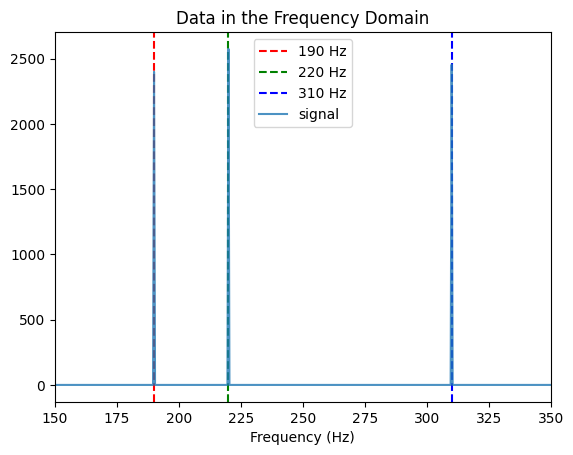

In [4]:
# Apply thresholding
threshold = 500  # Set threshold value
data_freq_filtered = np.where(np.abs(data_freq) > threshold, data_freq, 0)

plt.axvline(x=190, color='r', linestyle='--', label="190 Hz")
plt.axvline(x=220, color='g', linestyle='--', label="220 Hz")
plt.axvline(x=310, color='b', linestyle='--', label="310 Hz")
plt.plot(frequencies, np.abs(data_freq_filtered), label='signal', alpha=0.8)
plt.xlim(150,350)
plt.xlabel('Frequency (Hz)')
plt.title("Data in the Frequency Domain")
plt.legend()
plt.show()

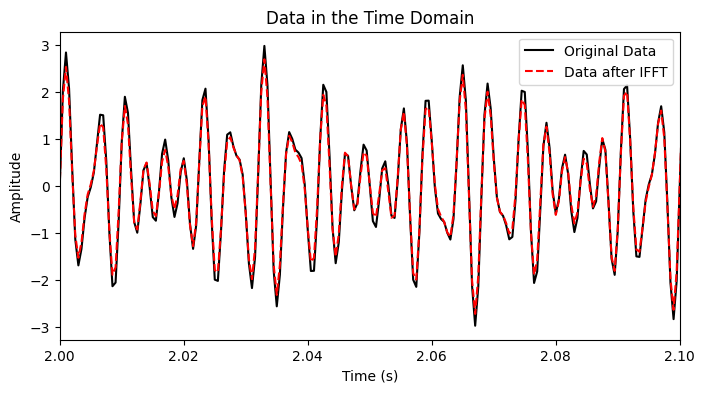

In [5]:
# -- Finally, we can transform back to the time domain
# -- using the "Inverse Fourier Transform"

data_after_ifft = np.fft.irfft(data_freq_filtered)

# Plot the original and reconstructed signals
plt.figure(figsize=(8, 4))
plt.plot(time, data, label='Original Data', color='k')
plt.plot(time, data_after_ifft, '--', label='Data after IFFT', color='r')

# Formatting
plt.xlim(2, 2.1)  # Zoom in on the time range
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Data in the Time Domain')
plt.legend(loc='upper right')

plt.show()

### Working with data from <a href='https://gwosc.org/'>Gravitational Wave Open Science Center</a>

* [GPS time](https://gwosc.org/gps) of the data of interest ([Learn more](https://www.google.com/search?q=What+is+gps+time))
* Detector could be H1 (LIGO Hanford), L1 (LIGO Livingston), or V1 (Virgo)

We will be looking at the first direct observation of gravitational waves last 14 September 2015 ([GW150914](https://en.wikipedia.org/wiki/First_observation_of_gravitational_waves) [\[GIF\]](https://x.com/NASAUniverse/status/1570095557825404928))

In [6]:
#Import and install packages

import requests, os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
    from gwpy.segments import Segment
except:
    ! pip install -q "gwpy==3.0.9" #(for gravitational wave data analysis)
    ! pip install -q "matplotlib==3.7.3" #(for plotting)
    ! pip install -q "astropy==6.1.4"#(astronomy-related computations)
    from gwpy.timeseries import TimeSeries

# -- Turn on interactive plotting
plt.ion()

In [7]:
# -- Set a GPS time:
t0 = 1126259462.4    # -- GW150914

#-- Detector 'H1' (LIGO Hanford)
detector = 'H1'

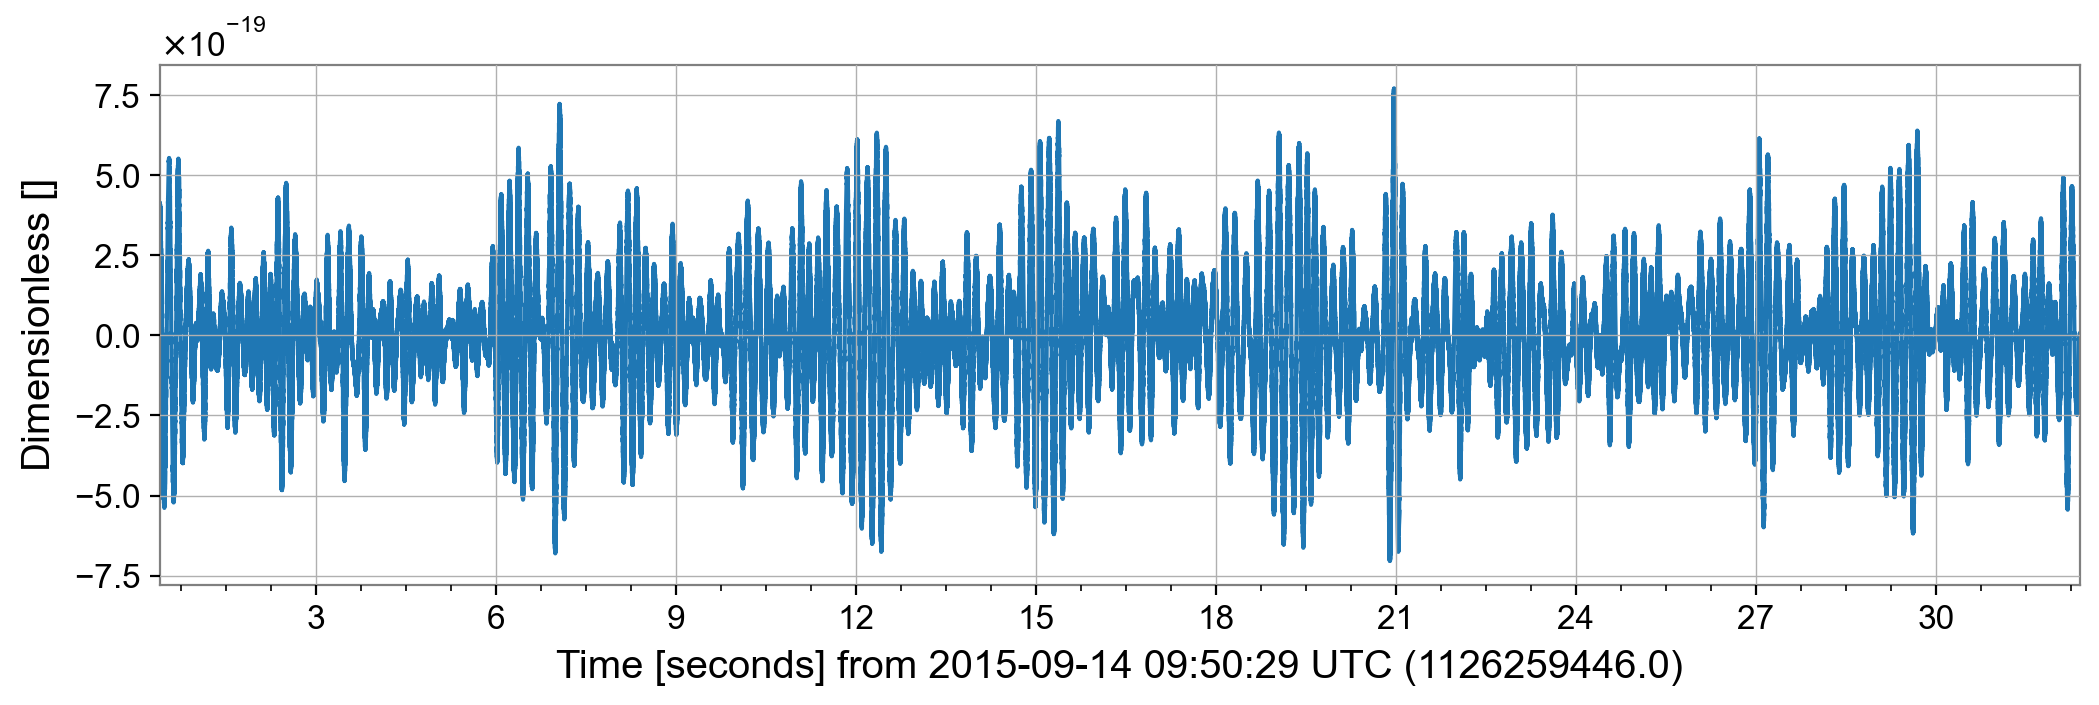

In [8]:
# Query and download data
t_pad=16
strain = TimeSeries.fetch_open_data(detector, t0-t_pad, t0+t_pad)
fig1 = strain.plot()

### Plot the Amplitude Spectral Density (ASD)

The amplitude spectral density is one way to visualize the frequency-domain content of a time series signal.
 * [ASDs in the gwpy](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.asd)
 * [ASDs in Wikipedia](https://en.wikipedia.org/wiki/Spectral_density)

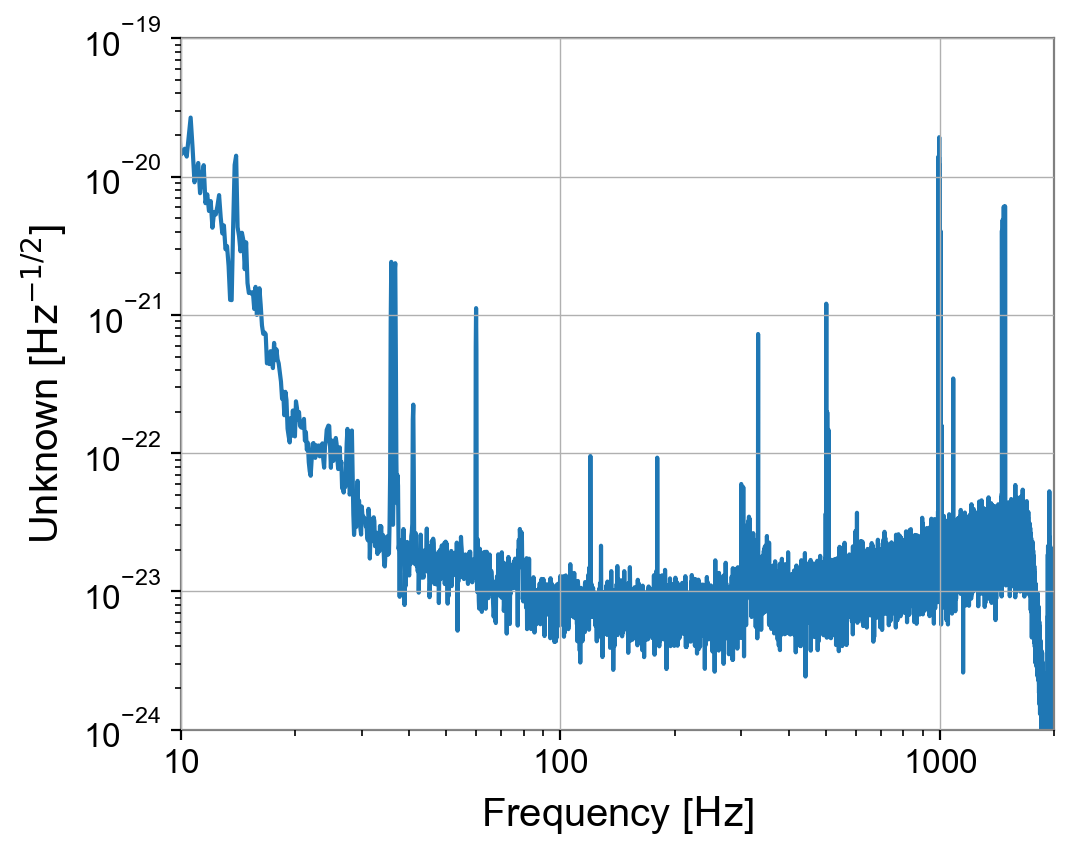

In [9]:
# Plot ASD
fig2 = strain.asd(fftlength=8).plot()
plt.xlim(10,2000)
plt.ylim(1e-24, 1e-19)
plt.show()

### Whiten and band-pass the data

* Whitening is a process that re-weights a signal, so that all frequency bins have a nearly equal amount of noise.
* A band-pass filter uses both a low frequency cutoff and a high frequency cutoff, and only passes signals in the frequency band between these values.

See also:

 * [Whitening a TimeSeries](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.whiten)
 * [Bandpass a TimeSeries](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.bandpass)

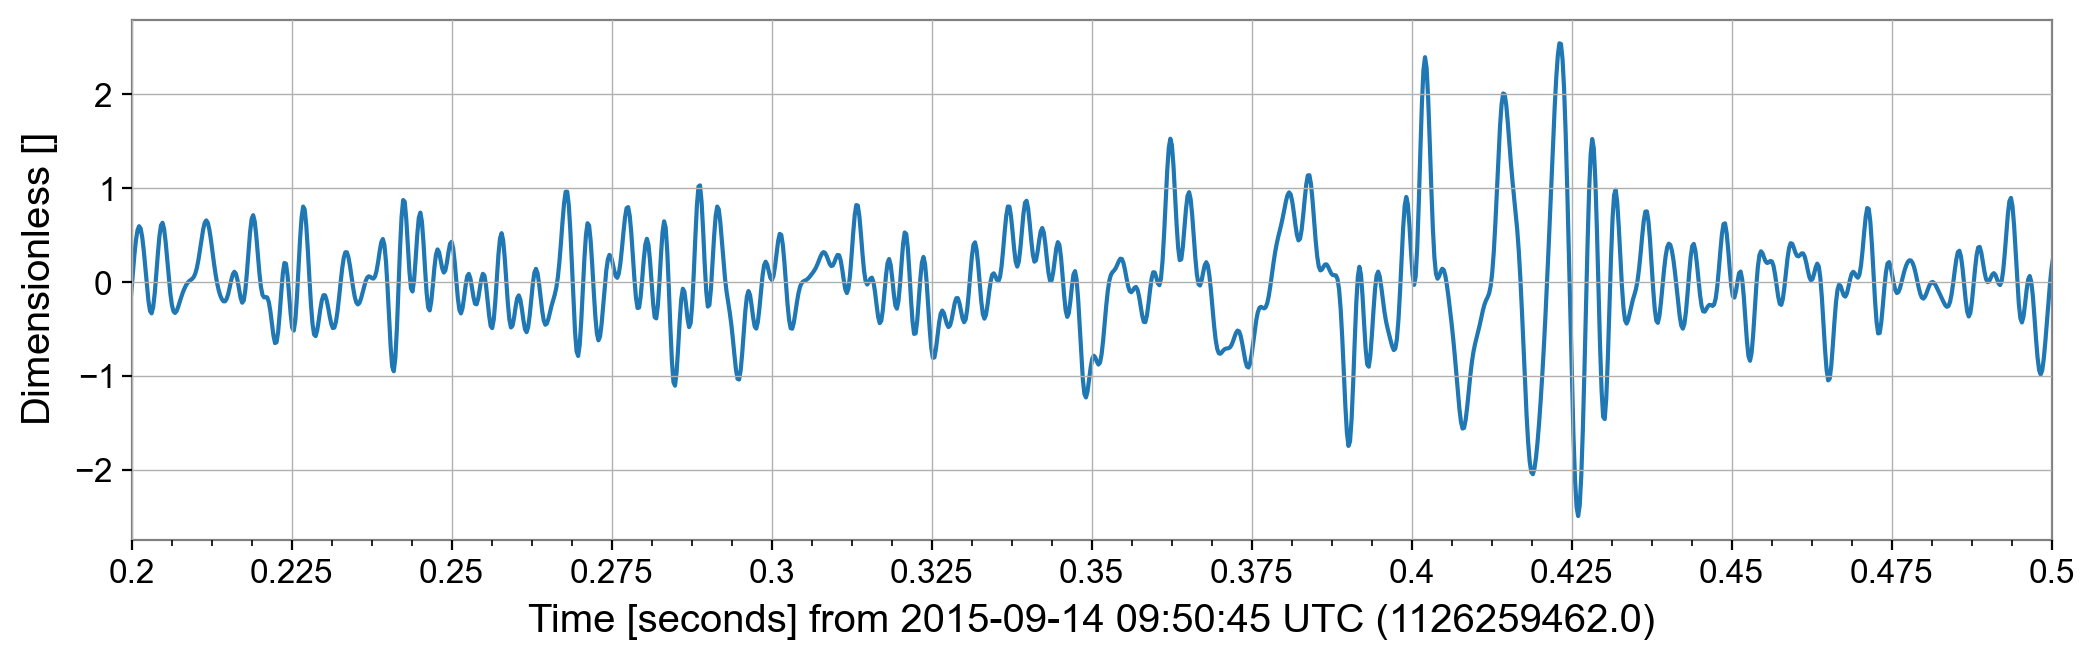

In [10]:
# -- Whiten and bandpass data
white_data = strain.whiten()
bp_data = white_data.bandpass(30, 400)
fig3 = bp_data.plot()
plt.xlim(t0-0.2, t0+0.1)
plt.show()

### Plot a q-transform of the data

A Q-transform plot shows how a signal’s frequency changes with time.

* The x-axis shows time
* The y-axis shows frequency
* The color scale shows the amount of “energy” or “signal power” in each time-frequency pixel.

A parameter called “Q” refers to the quality factor. A higher quality factor corresponds to a larger number of cycles in each time-frequency pixel.

* [Q-transform in gwpy](https://gwpy.github.io/docs/latest/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.q_transform)
* [Q-transform in Wikipedia](https://en.wikipedia.org/wiki/Constant-Q_transform)

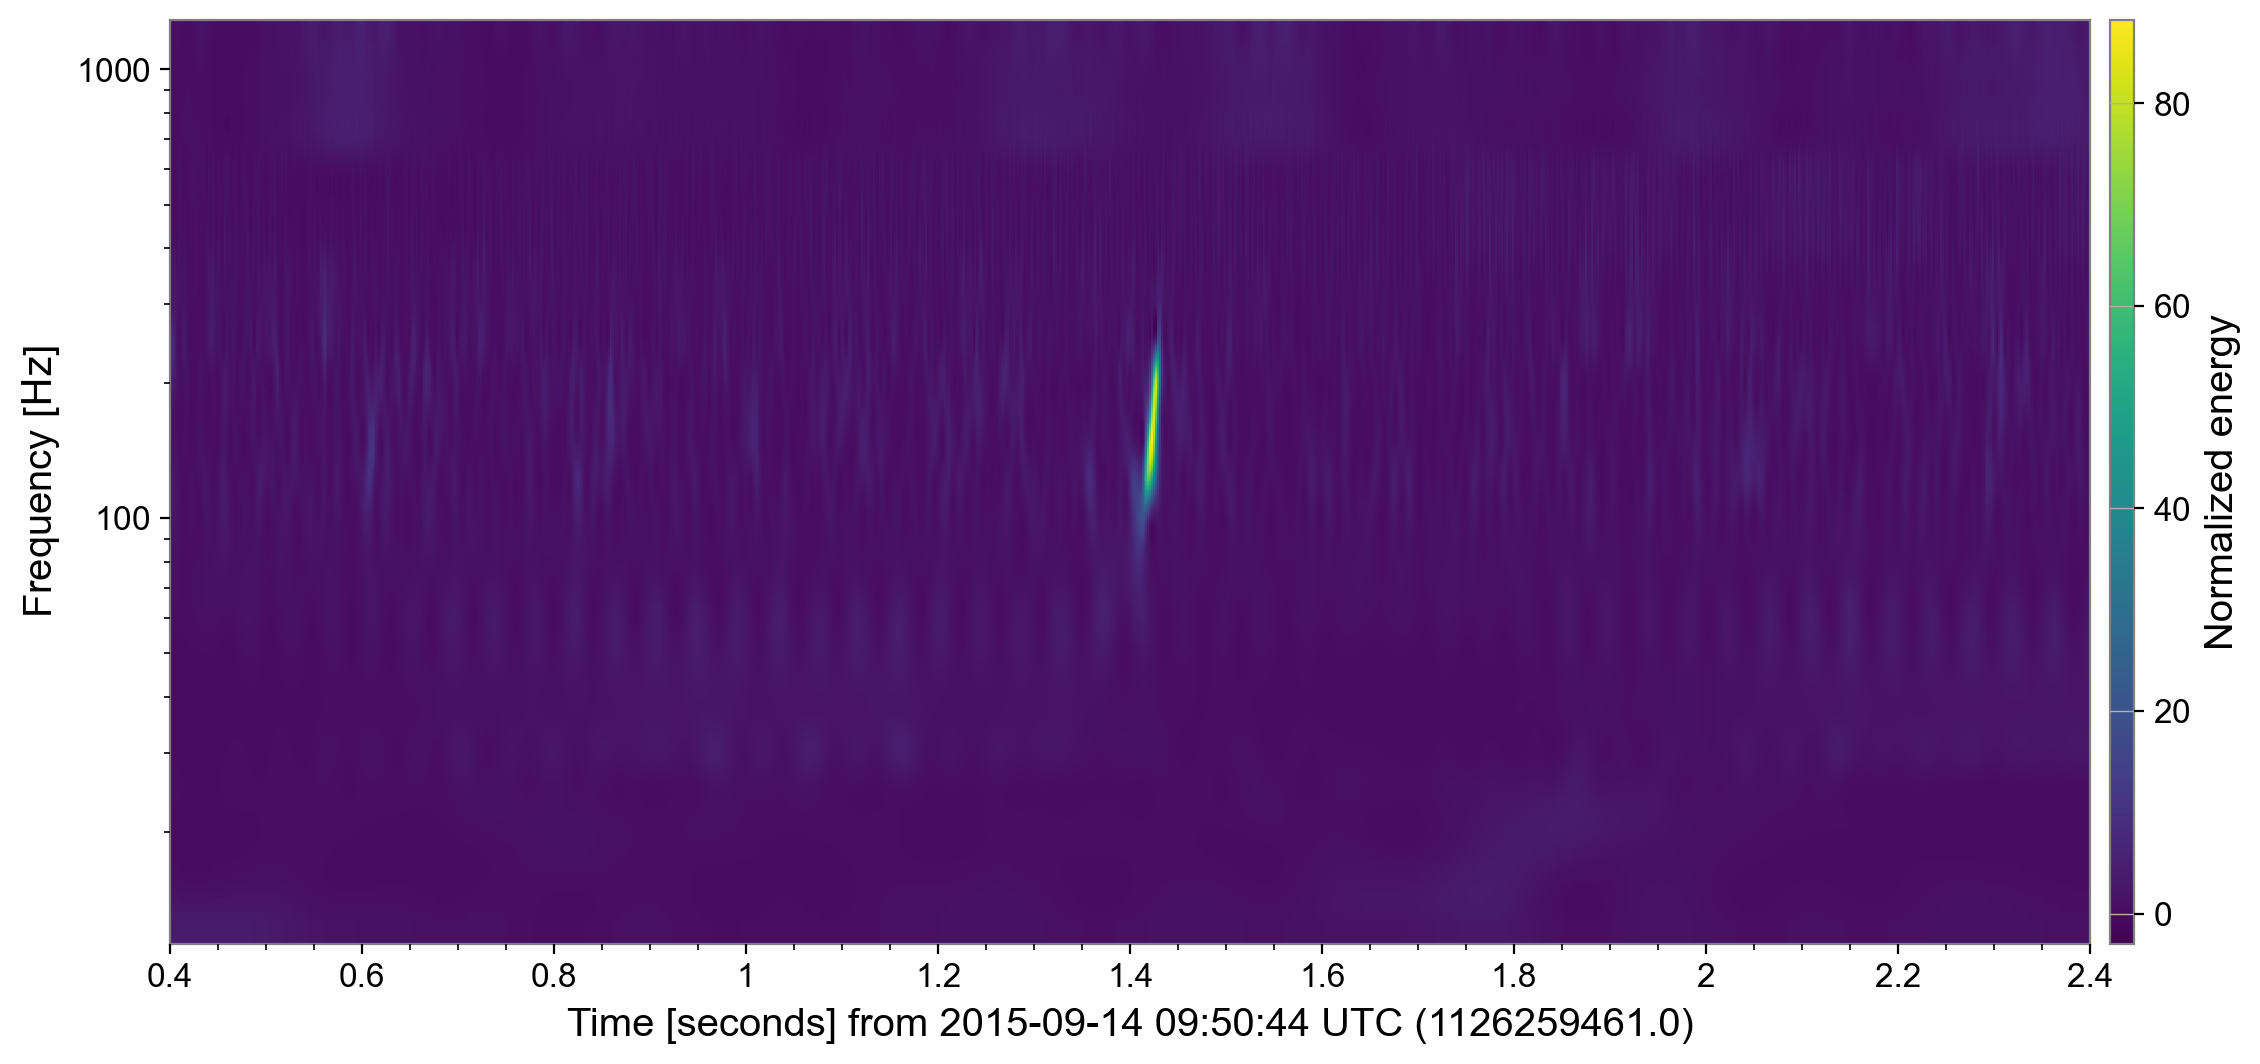

In [12]:
dt = 1  #-- Set width of q-transform plot, in seconds

hq = strain.q_transform(outseg=(t0-dt, t0+dt), whiten='False')
fig4 = hq.plot()
ax = fig4.gca()
ax.grid(False)
ax.set_yscale('log')
fig4.colorbar(label="Normalized energy")
plt.show()

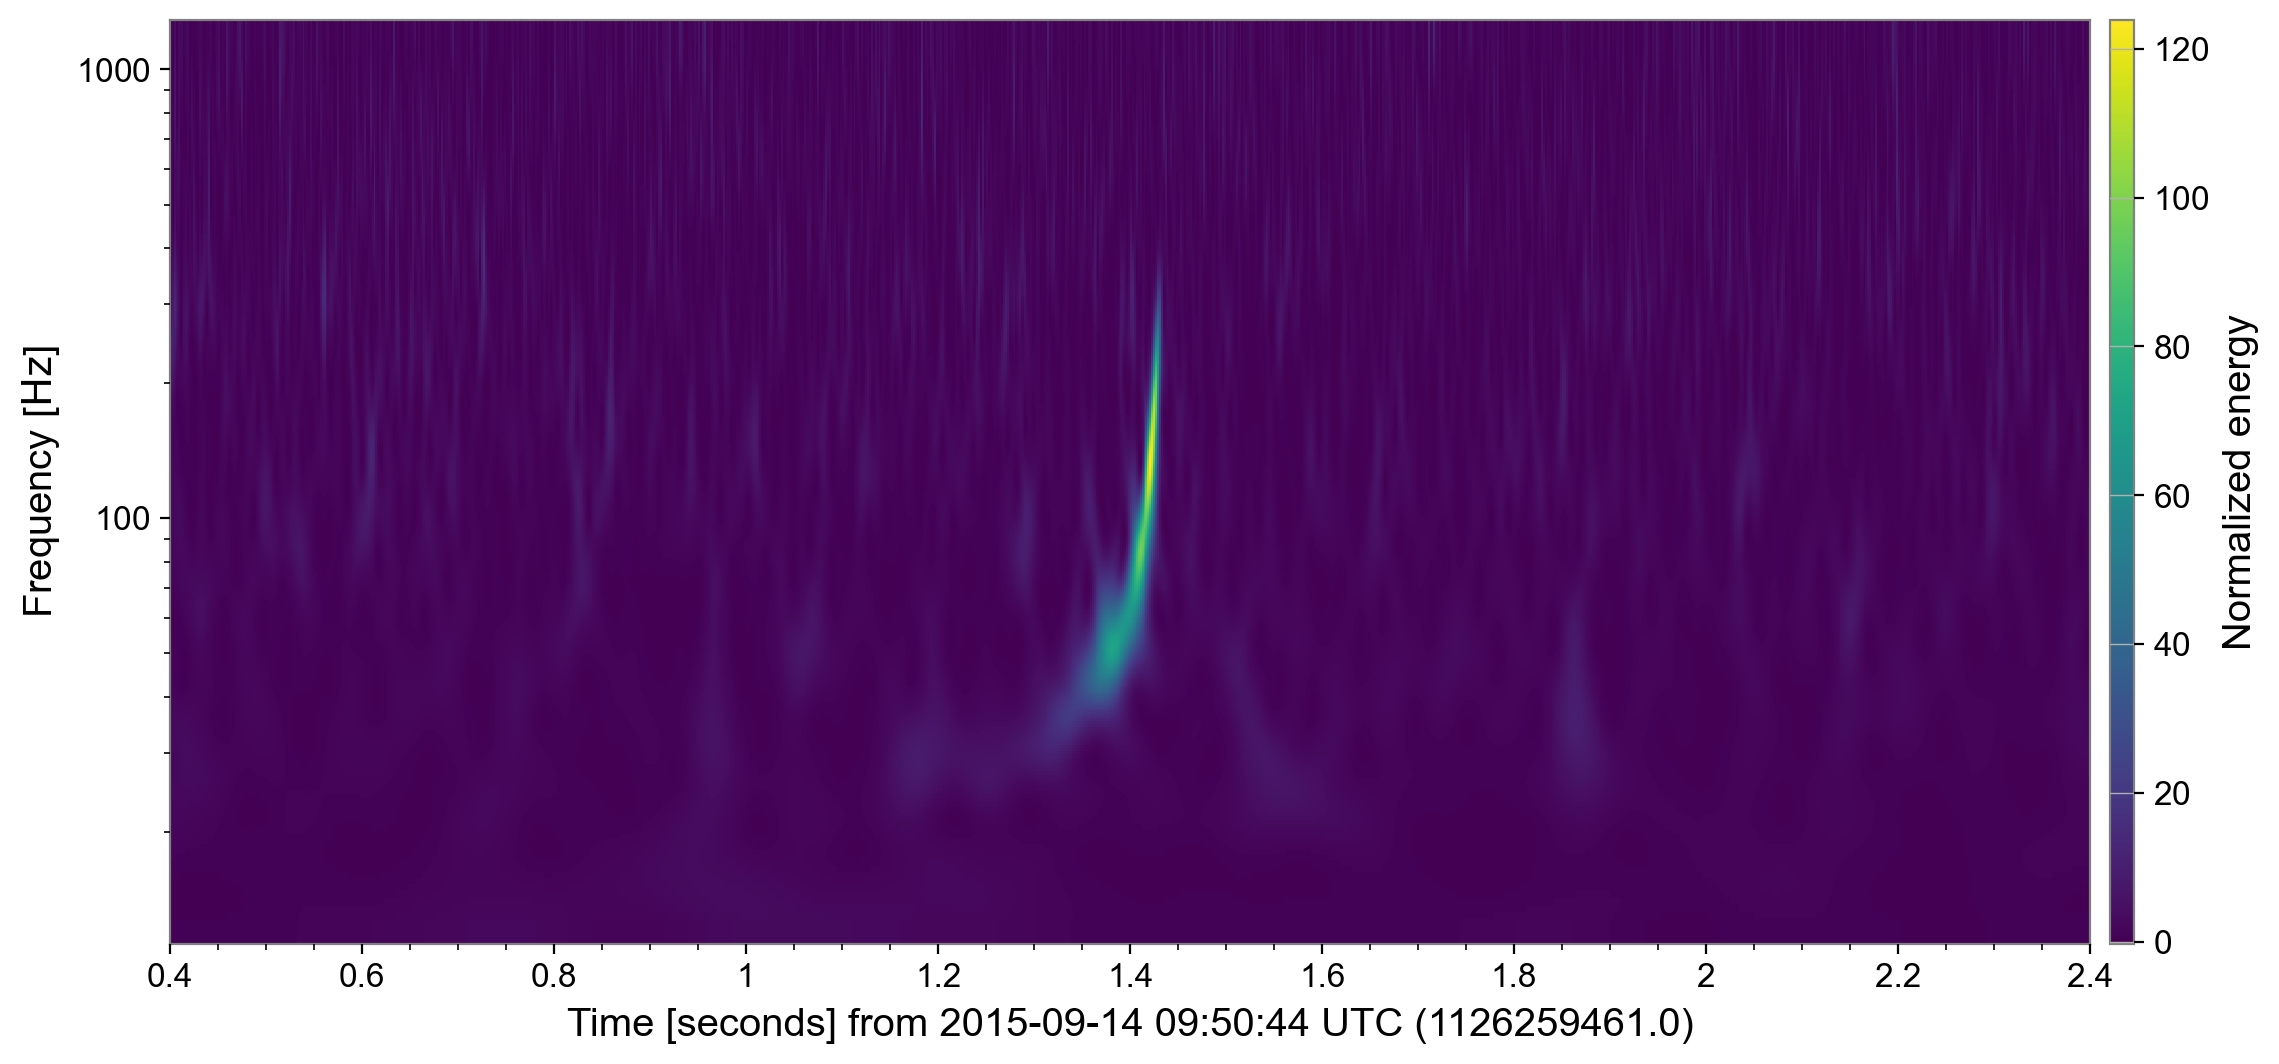

In [13]:
hq = bp_data.q_transform(outseg=(t0-dt, t0+dt))
fig4 = hq.plot()
ax = fig4.gca()
ax.grid(False)
ax.set_yscale('log')
fig4.colorbar(label="Normalized energy")
plt.show()

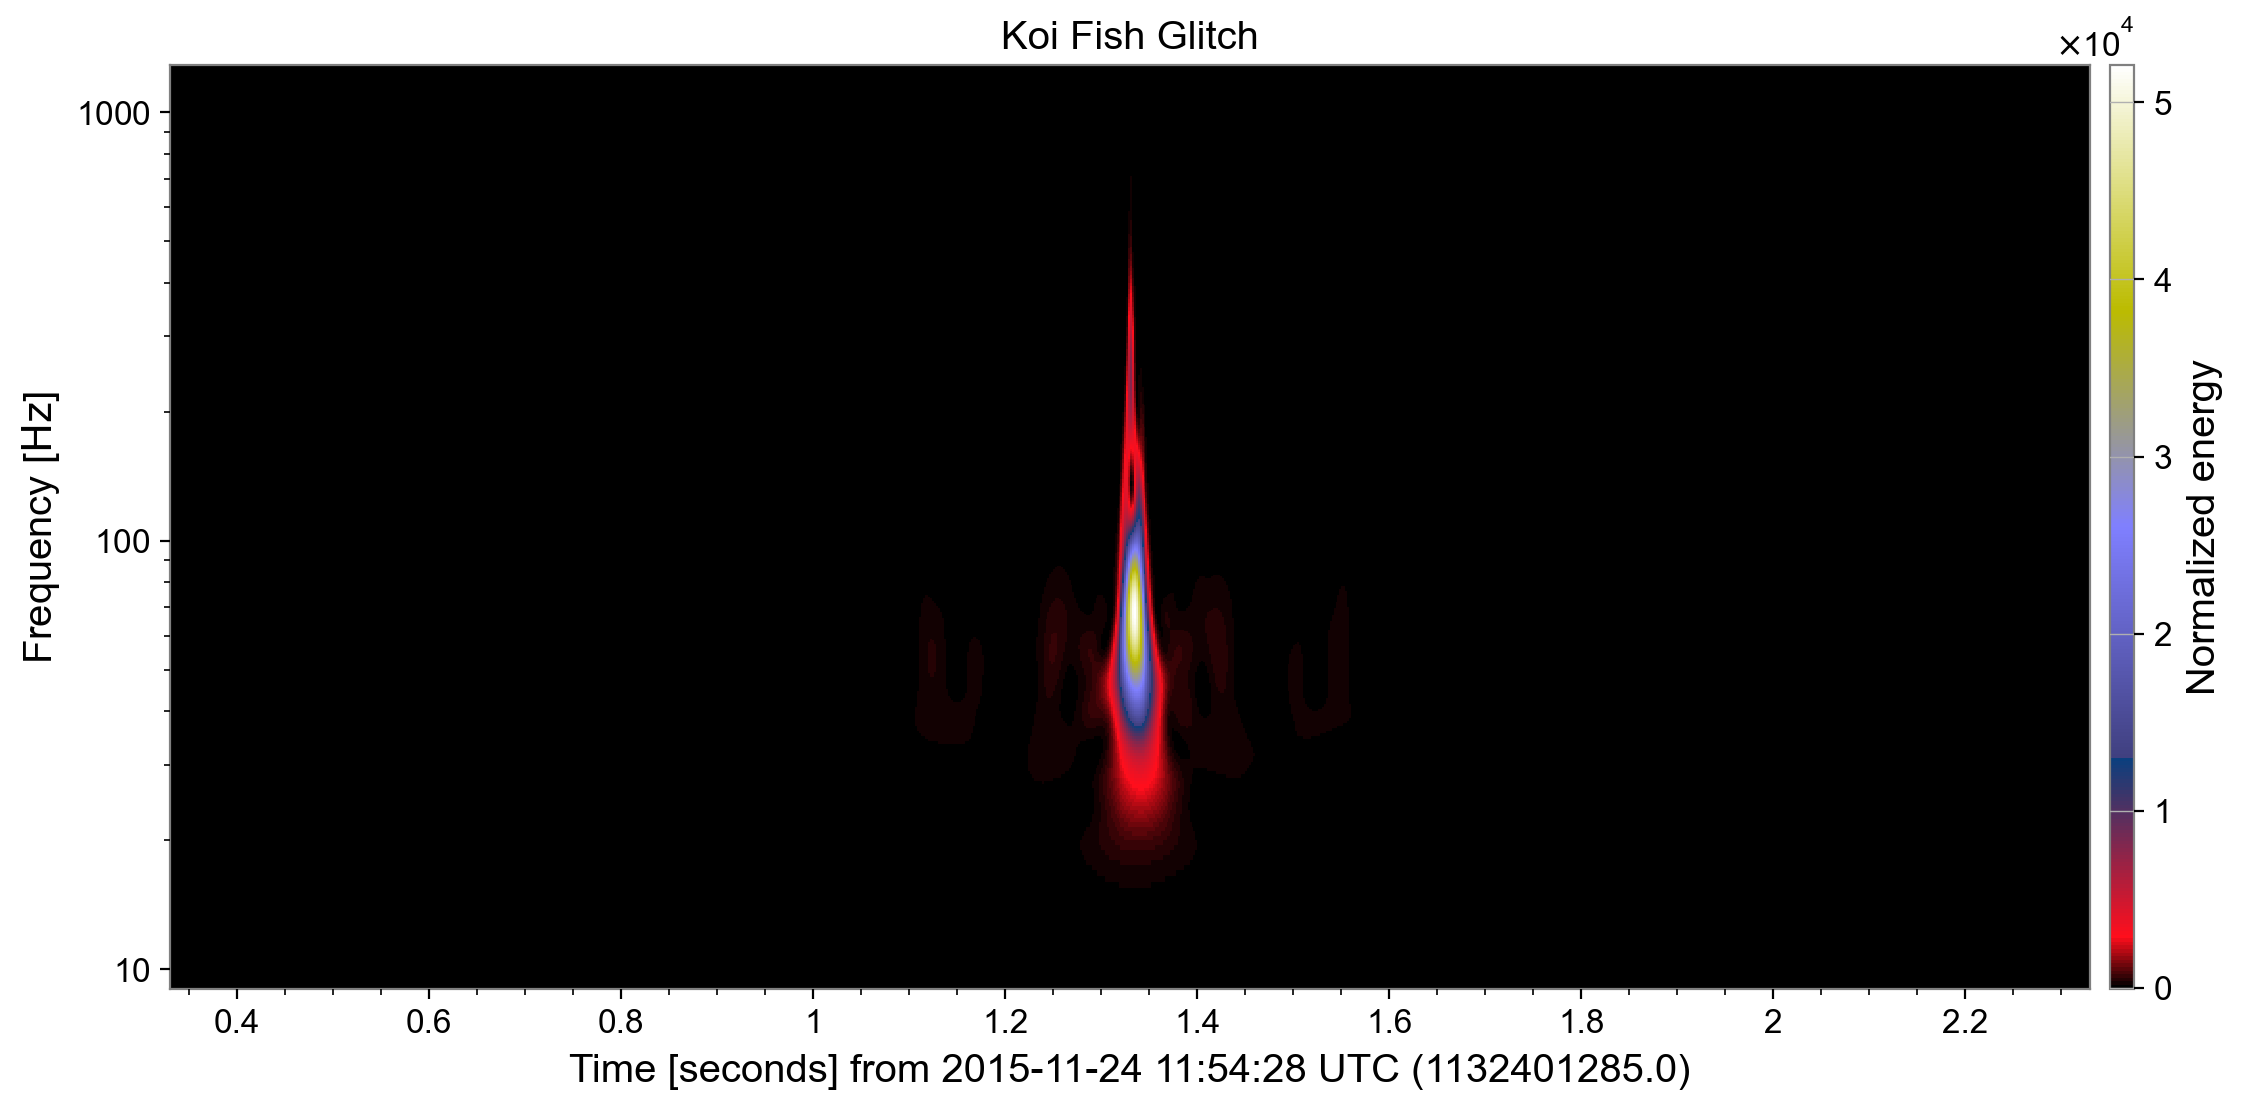

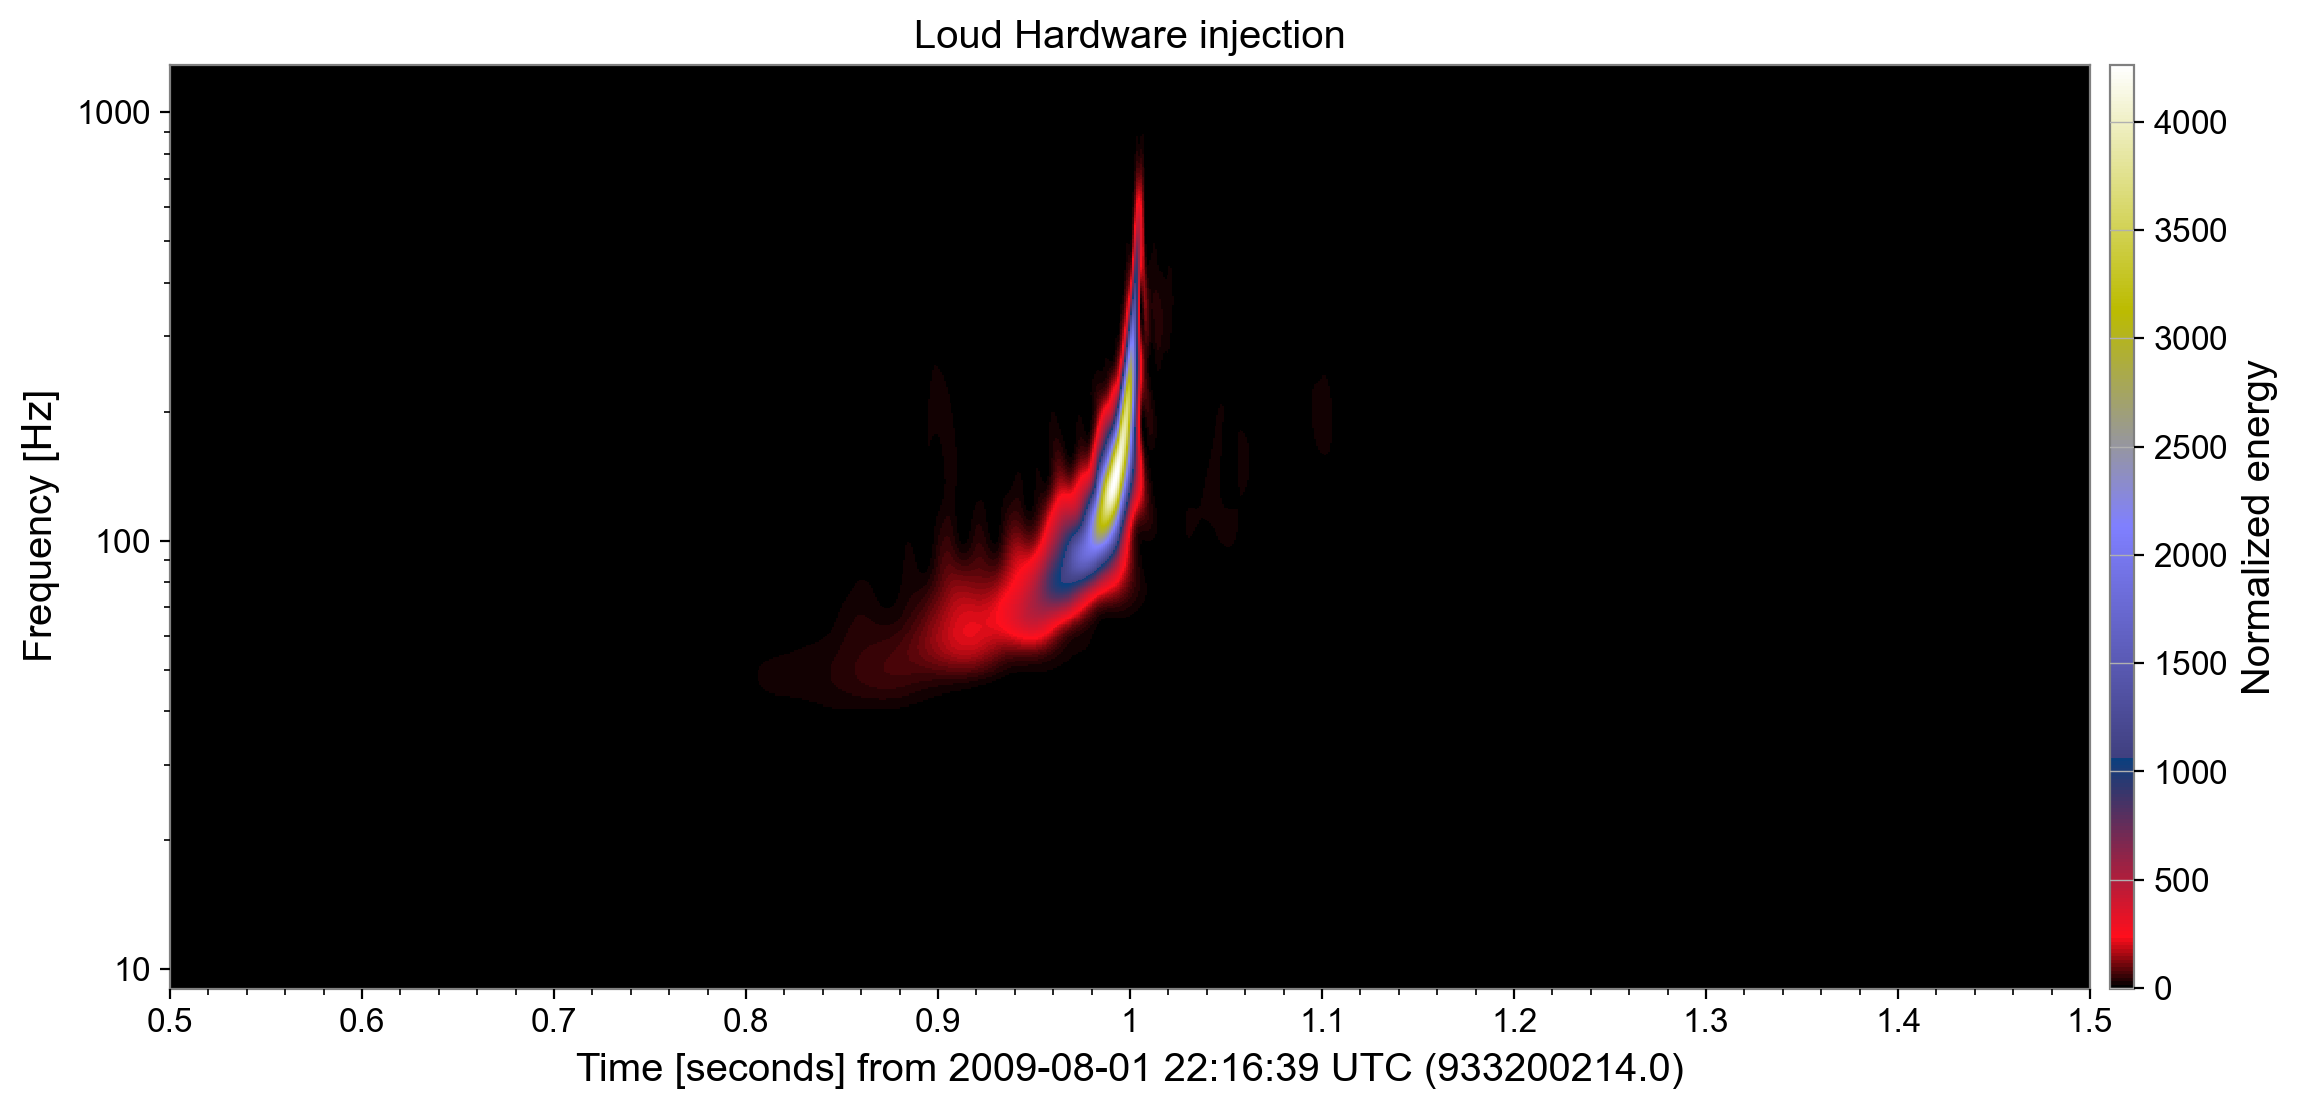

In [14]:
def plot_spect(t0, detector, title, pad=20,dt=dt):
    
    for t in t0:
        t0 = t
        detector = detector

        strain = TimeSeries.fetch_open_data(detector, t0-pad, t0+pad)

        dt = dt  #-- Set width of q-transform plot, in seconds
        hq = strain.q_transform(outseg=(t0-dt, t0+dt))
        fig4 = hq.plot(cmap='gist_stern')
        ax = fig4.gca()
        ax.grid(False)
        ax.set_yscale('log')
        ax.set_title(title)
        fig4.colorbar(label="Normalized energy")
        plt.show()

plot_spect([1132401286.33], 'H1', 'Koi Fish Glitch', dt=1)
plot_spect([933200215],'H1', 'Loud Hardware injection', dt=0.5)

In [15]:
gps = 1187008882.4
hdata = TimeSeries.fetch_open_data('H1', int(gps) - 30, int(gps) + 2)
ldata = TimeSeries.fetch_open_data('L1', int(gps) - 30, int(gps) + 2)
lq = ldata.q_transform(frange=(30, 500), qrange=(100, 110))
hq = hdata.q_transform(frange=(30, 500), qrange=(100, 110))

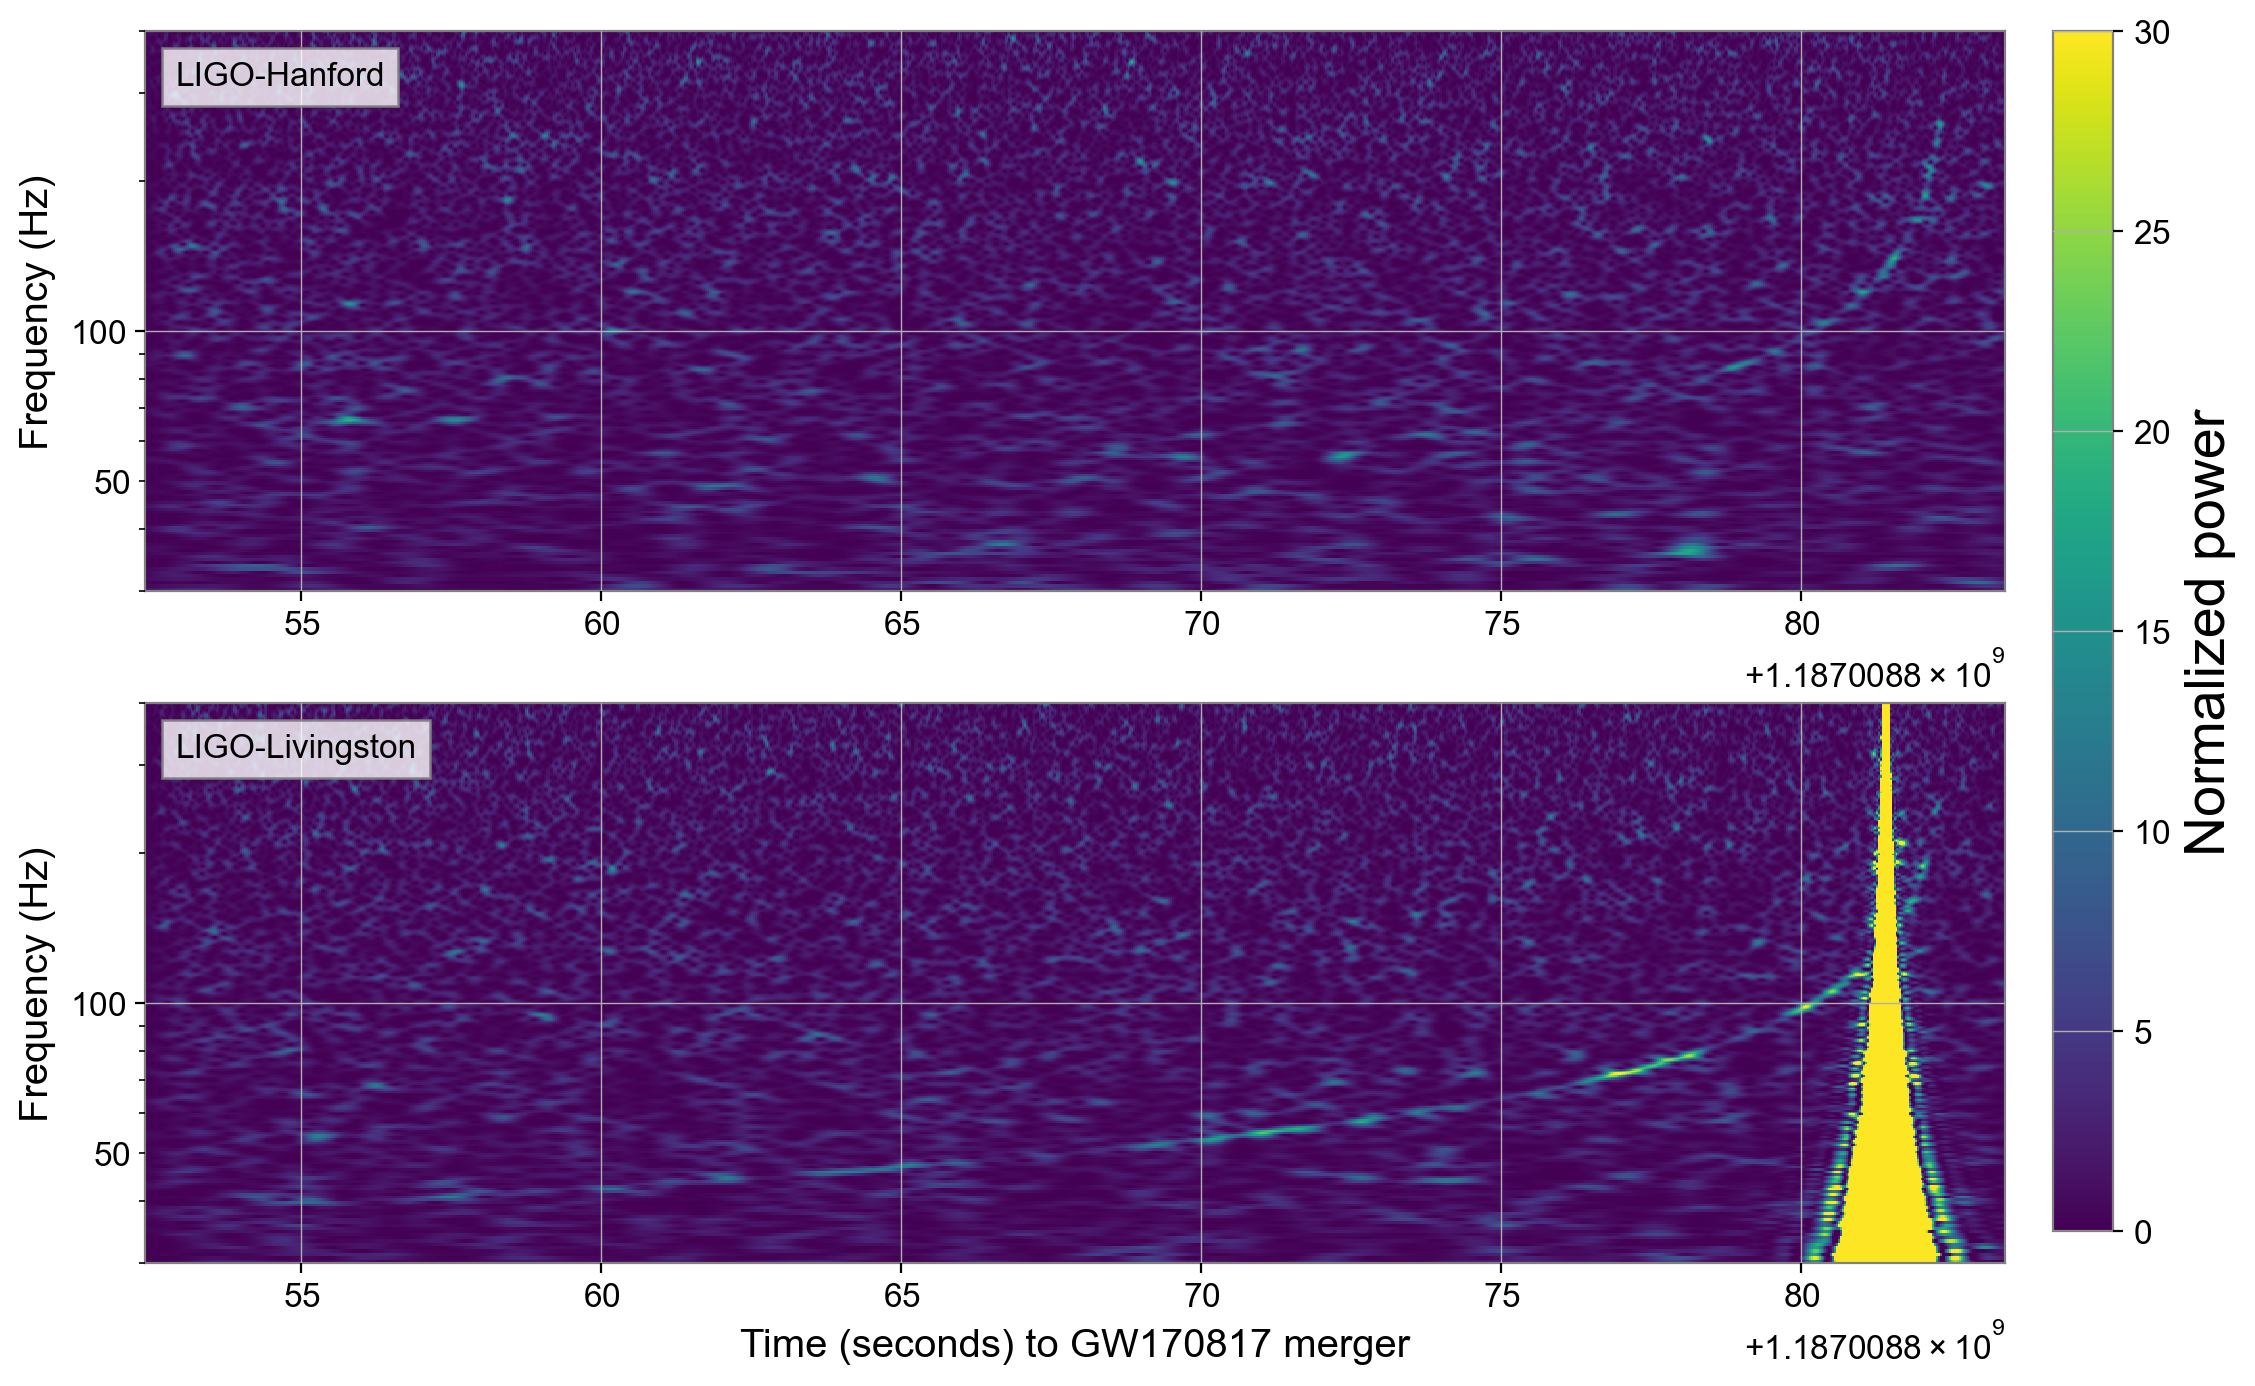

In [16]:
# create the figure and plot the data on separate axes
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

for ax, data, xlabel, detlabel in [(axs[0], hq, '', 'LIGO-Hanford'),(axs[1], lq, 'Time (seconds) to GW170817 merger', 'LIGO-Livingston')]:
    im=ax.pcolormesh(data, vmin=0, vmax=30)
    
    # add hidden elements that we can use for labelling
    ax.plot(gps, 0, label=detlabel, visible=False)
    ax.legend(loc='upper left', handlelength=0, handletextpad=0)

    # format the axes
    ax.set_xlim(gps-30, gps+1)
    ax.set_yscale('log')
    ax.set_ylim(30, 400)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency (Hz)')

# finalise
cax = plt.axes([0.92, 0.13, 0.025, 0.75])
cbar=fig.colorbar(im, cax=cax)
cbar.set_label('Normalized power',size='20')